In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pandas as pd
import pylhe
from tqdm import tqdm
import itertools

In [3]:
def f(deltaeta, deltaphi):
    return np.sqrt(deltaeta**2 + deltaphi**2)
def function(f_Att, cs):
    # Define Tree
    tree_electron_Att = f_Att['Delphes;1/Electron']
    tree_muon_Att = f_Att['Delphes;1/Muon']
    tree_jet_Att = f_Att['Delphes;1/Jet']
    tree_Emiss_Att = f_Att['Delphes;1/MissingET']
    tree_Ht_Att = f_Att['Delphes;1/ScalarHT']
    
    # Define Branches
    Att_electron = tree_electron_Att.arrays(['Electron.Charge',
                                            'Electron.PT',
                                            'Electron.Eta',
                                            'Electron.Phi'], library='ak')
    Att_muon = tree_muon_Att.arrays(['Muon.Charge',
                                    'Muon.PT',
                                    'Muon.Eta',
                                    'Muon.Phi'], library='ak')
    Att_jet = tree_jet_Att.arrays(['Jet.Mass',
                                   'Jet.BTag',
                                   'Jet.PT',
                                   'Jet.Eta', 
                                   'Jet.Phi'], library='ak')
    Att_Emiss = tree_Emiss_Att.arrays(['MissingET.MET',
                                       'MissingET.Phi'], library='ak')
    Att_Ht = tree_Ht_Att.arrays(['ScalarHT.HT'])
    
    # Define Variables
    EventSize = len(Att_jet['Jet.Mass'])
    jet_sort_pt = ak.sort(Att_jet['Jet.PT'], axis=-1, ascending=False)
    jet_num = ak.num(Att_jet['Jet.PT'], axis=-1)
    lepton_sort_pt = ak.sort(ak.concatenate([Att_electron['Electron.PT'], Att_muon['Muon.PT']], axis=-1), axis=-1, ascending=False)
    lepton_charge = ak.Array.tolist(ak.concatenate([Att_electron['Electron.Charge'], Att_muon['Muon.Charge']], axis=-1))
    lepton_eta = ak.concatenate([Att_electron['Electron.Eta'], Att_muon['Muon.Eta']], axis=-1)
    lepton_phi = ak.concatenate([Att_electron['Electron.Phi'], Att_muon['Muon.Phi']], axis=-1)
    bjet_pt = Att_jet['Jet.PT']*Att_jet['Jet.BTag']
    bjet_eta = Att_jet['Jet.Eta']*Att_jet['Jet.BTag']
    bjet_phi = Att_jet['Jet.Phi']*Att_jet['Jet.BTag']
    two_lepton = ak.where(ak.num(lepton_sort_pt)>=2)
    
    # Two leptons with same charge + at least 3 jets with 2 of them identified as b-jets
    event_signal = []
    for i in tqdm(two_lepton[0]): #Awkward Array has a length of 1
        num_jet, b_pt, lep_charge = jet_num[i], bjet_pt[i], lepton_charge[i]
        num_bjet = len(b_pt[ak.where(b_pt)])
        if lep_charge.count(-1) >= 2 or lep_charge.count(1) >=2:
            if num_jet >= 3 and num_bjet >=2:
                event_signal.append(i)
        
    # Transverse Momentum of leading and subleading lepton & Eta for Leptons
    event_lep = []
    for i in tqdm(event_signal):
        lep_eta = lepton_eta[i]
        lep_where = ak.where(np.abs(lep_eta)<2.5, 0, lep_eta)
        if lepton_sort_pt[i][0] > 25 and lepton_sort_pt[i][1] > 20 and ak.count_nonzero(lep_where) == 0:
            event_lep.append(i)
        else:
            continue
    
    # Transverse Momentum of three jets
    event_jet = []
    for i in tqdm(event_lep):
        if jet_sort_pt[i][2] > 20:
            event_jet.append(i)
        else:
            continue
    
    # Emiss
    event_emiss = []
    for i in tqdm(event_jet):
        if Att_Emiss['MissingET.MET'][i] > 30:
            event_emiss.append(i)
        else:
            continue
 
    # delta R between b-jets and leptons, leptons and leptons, b-jets and b-jets
    event_deltaR_jl = []
    for i in tqdm(event_emiss):
        lep_eta, lep_phi, jeta, jphi = lepton_eta[i], lepton_phi[i], Att_jet['Jet.Eta'][i], Att_jet['Jet.Phi'][i]

        deltaeta_jl = np.array([i-j for i in jeta for j in lep_eta])
        deltaphi_jl = np.abs([i-j for i in jphi for j in lep_phi])
        deltaphi_jl = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_jl])
    
        if min(f(deltaeta_jl, deltaphi_jl)) > 0.4:
            event_deltaR_jl.append(i)
    
    event_deltaR_bb = []
    for i in tqdm(event_deltaR_jl):
        b_eta, b_phi = bjet_eta[i], bjet_phi[i]
        b_eta, b_phi = b_eta[ak.where(b_eta)], b_phi[ak.where(b_phi)]
        
        m = b_eta - b_eta[:, np.newaxis]
        deltaeta_bb = m[np.triu_indices(len(m[0]), k = 1)]
        m = b_phi - b_phi[:, np.newaxis]
        deltaphi_bb = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_bb = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_bb])
        
        if min(f(deltaeta_bb, deltaphi_bb)) > 0.4:
            event_deltaR_bb.append(i)
            
    event_deltaR_ll = []
    for i in tqdm(event_deltaR_bb):
        lep_eta, lep_phi = lepton_eta[i], lepton_phi[i]
        m = lep_eta - lep_eta[:, np.newaxis]
        deltaeta_ll = m[np.triu_indices(len(m[0]), k = 1)]
        m = lep_phi - lep_phi[:, np.newaxis]
        deltaphi_ll = np.abs(m[np.triu_indices(len(m[0]), k = 1)])
        deltaphi_ll = np.array([2*np.pi-i if i > np.pi else i for i in deltaphi_ll])

        if min(f(deltaeta_ll, deltaphi_ll)) > 0.4:
            event_deltaR_ll.append(i)
    
    # HT of 2 leading leptons and three leading jets
    event_ht = []
    for i in tqdm(event_deltaR_ll):
        lep_pt, jet_pt = lepton_sort_pt[i], jet_sort_pt[i]
        ht = np.sum([lep_pt[0], lep_pt[1], jet_pt[0], jet_pt[1], jet_pt[2]])
        if ht > 300:
            event_ht.append(i)
    
    cs = cs * 1000
    csf = round(cs * len(event_ht)/EventSize, 2)
                
    return [EventSize, len(event_signal), len(event_lep), len(event_jet), len(event_emiss), len(event_deltaR_jl), len(event_deltaR_bb), len(event_deltaR_ll), len(event_ht), cs, csf]

In [4]:
root_dirs = '../root/MG5_aMC_v2_7_3/test4/Events/'
root_names = ['run_01/tag_2_delphes_events.root', 'run_02/tag_2_delphes_events.root',
             'run_03/tag_2_delphes_events.root', 'run_04/tag_1_delphes_events.root',
             'run_05/tag_1_delphes_events.root']
f_tA = [uproot.open(root_dirs + name) for i, name in enumerate(root_names)]

In [5]:
# Cross Section From Madgraph Generation After Merging and Matching
cs = np.array([0.1345, 0.08563, 0.04107, 0.02086, 0.01086])

In [6]:
m1 = function(f_tA[0], cs[0])
m2 = function(f_tA[1], cs[1])
m3 = function(f_tA[2], cs[2])
m4 = function(f_tA[3], cs[3])
m5 = function(f_tA[4], cs[4])

100%|██████████| 237/237 [00:00<00:00, 1888.78it/s]


In [7]:
m = [m1, m2, m3, m4, m5]
f = np.array([m[i][8]/m[i][0] for i in range(len(m))])
m1

[3164, 327, 269, 269, 224, 224, 224, 220, 142, 134.5, 6.04]

In [8]:
name = [r'Input Event Size',
        'SS2t Signature',
        r'Jet Selection',
        r'lepton Selection',
        r'$E_{T}^{miss}$ > 30GeV',
        r'Δ$R_{jl}$ > 0.4',
        r'Δ$R_{bb}$ > 0.4',
        r'Δ$R_{ll}$ > 0.4',
        r'$H_{T}$ (2 leading leptons & 3 leading jets) > 300 GeV',
        'Cross Section after Merging and Matching (fb)',
        'Cross Section after Selection Cut (fb)']
fd = pd.DataFrame({r'Selection Cut (SS2t) $(M_{A}=M_{H}+50GeV)$ $\rho_{tc}=1$': name,
                   r'$M_{H}=200 GeV$': m1,
                   r'$M_{H}=300 GeV$': m2,
                   r'$M_{H}=400 GeV$': m3,
                   r'$M_{H}=500 GeV$': m4,
                   r'$M_{H}=600 GeV$': m5
                   })
fd

,Selection Cut (SS2t) $(M_{A}=M_{H}+50GeV)$ $\rho_{tc}=1$,$M_{H}=200 GeV$,$M_{H}=300 GeV$,$M_{H}=400 GeV$,$M_{H}=500 GeV$,$M_{H}=600 GeV$
0,Input Event Size,3164.00,3085.00,2897.00,2744.00,2542.00
1,SS2t Signature,327.00,375.00,373.00,355.00,342.00
2,Jet Selection,269.00,279.00,284.00,268.00,267.00
3,lepton Selection,269.00,279.00,284.00,268.00,267.00
4,$E_{T}^{miss}$ > 30GeV,224.00,236.00,255.00,247.00,243.00
5,Δ$R_{jl}$ > 0.4,224.00,236.00,255.00,247.00,243.00
6,Δ$R_{bb}$ > 0.4,224.00,236.00,255.00,247.00,243.00
7,Δ$R_{ll}$ > 0.4,220.00,234.00,250.00,239.00,237.00
8,$H_{T}$ (2 leading leptons & 3 leading jets) >...,142.00,194.00,230.00,234.00,233.00
9,Cross Section after Merging and Matching (fb),134.50,85.63,41.07,20.86,10.86


In [10]:
def uncer(l, n):
    return(np.sqrt(f*(1-f)/n))
es = np.array([3164, 3085, 2897, 2744, 2542])
uf = uncer(f, es)

<Figure size 432x288 with 0 Axes>

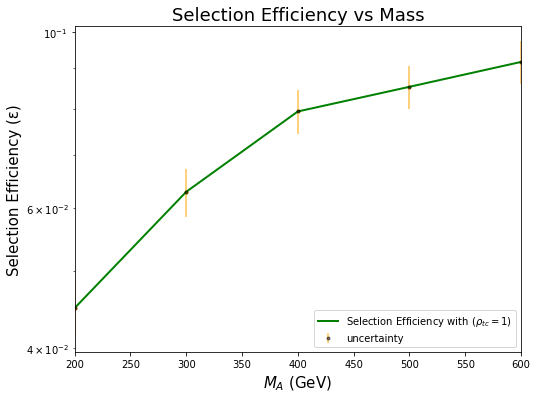

In [11]:
plt.figure()
m = [200, 300, 400, 500, 600]

plt.figure(figsize=(8, 6))
plt.scatter(m, f, marker='.', c = 'orange')
plt.xlim(200, 600)
plt.yscale('log')
plt.plot(m, f, 'g-', label=r'Selection Efficiency with ($\rho_{tc}=1$)', linewidth=2)
plt.errorbar(m, f, yerr=uf, fmt='.', color='black', ecolor='orange', elinewidth=2, alpha=0.5, capsize=0, label='uncertainty')
plt.title('Selection Efficiency vs Mass', fontsize=18)
plt.xlabel(r'$M_{A}$ (GeV)', fontsize=15)
plt.ylabel('Selection Efficiency (ε)', fontsize=15)
plt.legend(loc='lower right')
plt.show()